In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from sympy import *

## The Classical Rodrigues Parameters (CRPs).

The CRP directional cosine matrix is:

$$
[C] = \frac{1}{1 + q^Tq} \left[\begin{array}{cc} 
1 + q_1^2 - q_2^2 - q_3^2 & 2(q_1q_2 + q_3) & 2(q_1q_3 - q_2)\\
2(q_1q_2 - q_3) & 1 - q_1^2 + q_2^2 - q_3^2 & 2(q_2q_3 + q_1) \\
2(q_1q_3 + q_2) & 2(q_2q_3 - q_1) & 1 - q_1^2 - q_2^2 + q_3^2 
\end{array}\right] 
$$

In [4]:
#Classic Rodrigues Parameters.

"""
Given a set of Rodrigues parameters "q" (i.e: q_B/N of the body relative to the inertial frame), 
one can find the corresponging DCM.

"""

def CRP_to_DCM(q):
    
    q_1, q_2, q_3 = q
    
    C = np.array([[1 + q_1**2 - q_2**2 - q_3**2, 2 * (q_1 * q_2 + q_3), 2 * (q_1 * q_3 - q_2)],
                  [2 * (q_2 * q_1 - q_3), 1 - q_1**2 + q_2**2 - q_3**2, 2 * (q_2 * q_3 + q_1)],
                  [2 * (q_3 * q_1 + q_2), 2 * (q_3 * q_2 - q_1), 1 - q_1**2 - q_2**2 + q_3**2]],
                  dtype = np.float64)
    
    K = 1 / (1 + np.dot(q.T, q))
    
    return K * C


q = np.array([0.1, 0.2, 0.3])
    
CRP_to_DCM(q)

array([[ 0.77192982,  0.56140351, -0.29824561],
       [-0.49122807,  0.8245614 ,  0.28070175],
       [ 0.40350877, -0.07017544,  0.9122807 ]])

The inverse mapprings from the DCM to the CRPs are as follows:

$$
\zeta = \sqrt{Trace[C] + 1}
$$

$$
\frac{1}{\zeta^2} \left[\begin{array}{cc} 
C_{23} - C_{32} \\
C_{31} - C_{13} \\
C_{12} - C_{21} 
\end{array}\right] 
$$

In [5]:
def DCM_to_CRP(C):
    
    Z = np.sqrt(C.trace() + 1)
    
    return (1 / Z**2) * np.array([[C[1][2] - C[2][1]], 
                                  [C[2][0] - C[0][2]], 
                                  [C[0][1] - C[1][0]]])

In [6]:
C = np.array([[ 0.333333, -0.666667,  0.666667],
              [ 0.871795,  0.487179, 0.0512821],
              [-0.358974,  0.564103,   0.74359]])

DCM_to_CRP(C)

array([[-0.2000002 ],
       [-0.40000008],
       [-0.60000031]])

## CRP Kinematic Differential Equations:

$$
[\dot{\beta}]
=
\frac{1}{2}
\left[\begin{array}{cc} 
1 + \beta_1^2 & \beta_1\beta_2 - \beta_3 & \beta_1\beta_3 + \beta_2\\
\beta_2\beta_1 + \beta_3 & 1 + \beta_2^2 & \beta_3\beta_2 - \beta_1\\
\beta_3\beta_1 - \beta_2 & \beta_3\beta_2 + \beta_1 & 1 + \beta_3^2
\end{array}\right]
.
\left(\begin{array}{cc} 
\omega_1\\
\omega_2\\
\omega_3
\end{array}\right) 
$$

In [7]:
#Initial Conditions:
dt = 0.001
T = 42
N = int(T/dt)
y0 = np.array([0.4, 0.2, -0.1])
t = 0

"""
The RK4 (Runge-Kutte) integrator is implemented to solve the first order kinematic odes. the notation between q and "beta" are
used interchangably.

"""


def CRP_Kinematic_Eq(t, y):
    
    q_1, q_2, q_3 = y
    
    Q = np.array([[1 + q_1**2, q_1 * q_2 - q_3, q_1 * q_3 + q_2],
                  [q_2 * q_1 + q_3, 1 + q_2**2, q_2 * q_3 - q_1],
                  [q_3 * q_1 - q_2, q_3 * q_2 + q_1, 1 + q_3**2]])
    
    w = np.array([sin(0.1 * t), 0.01, cos(0.1 * t)])
    
    k = np.deg2rad(3)
    
    dQdt = np.dot(Q, w) * k * 1/2
    
    return dQdt



def RK4(f, dt, y0, t):
    
    y_plot = np.zeros((N-1,3))
    t_plot = []
                      
    for i in range(0, N-1): 
    
        f1 = f(t, y0)
        f2 = f(t + (dt / 2), y0 + (dt / 2) * f1)
        f3 = f(t + (dt / 2), y0 + (dt / 2) * f2)
        f4 = f(t + dt, y0 + dt * f3)
    
        y0 = y0 + (dt / 6) * (f1 + 2 * f2 + 2 * f3 + f4)
        
        t = t + dt
        
        y_plot[i] = y0; t_plot.append(t)
    
    return y_plot, t_plot


solution = RK4(CRP_Kinematic_Eq, dt, y0, t)

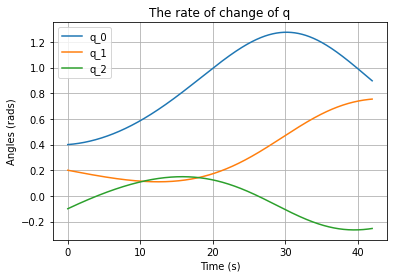

In [6]:
plt.plot(solution[1], solution[0][:,0], label = "q_0")
plt.plot(solution[1], solution[0][:,1], label = "q_1")
plt.plot(solution[1], solution[0][:,2], label = "q_2")

plt.legend()
plt.title("The rate of change of q")
plt.xlabel("Time (s)")
plt.ylabel("Angles (rads)")
plt.grid(true)

In [4]:
#Finding the norm of the vector (i.e: sqrt(q_1^2 + q_2^2 + q_3^2)) at 42s.
print(sqrt((solution[0][:,0][-1])**2 + (solution[0][:,1][-1])**2 + (solution[0][:,2][-1])**2 ))

1.19970670772359
